## 1D PIC (evolution_version) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{-\frac{v^2}{2\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")

nthreads = 1


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")

test_parameters (generic function with 1 method)

In [3]:
undumped = false
dumped = false
#undumped = true
dumped = true

true

In [4]:
if undumped
    run_name = "landau_undumped_"
    const L = 39.738 
    const J = 3522
elseif dumped
    run_name = "landau_dumped_"
    const L = 7.455
    const J = 930
end
order = 5
const N = 80_000
#const N = 8_000_000
exp_Theta = 3
exp_t = 1
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 10.0^(exp_t)
M = 11
M_g = 10 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0
#M = convert(Int64,t_f/dt)
#M=1
const κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)

println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

animation = false
phase_space_show = false

run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N2_5_J$(J)_M$(M)_o$(order)_T$(exp_Theta)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

t_f = 100.0, M = 1001, dt = 0.1, exp_Theta = 3
landau_dumped_big_8_6_tft100_L7.455_N2_5_J930_M1001_o5_T3


We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 


We build the initial data:

In [23]:
E = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E


In [24]:
if undumped
    #par_dis = load("Initial_Distributions/par_dis_nodupming.jld2", "par_dis");
    par_dis = load("Initial_Distributions/par_dis_dupming.jld2", "par_dis");
elseif dumped
    par_dis = load("Initial_Distributions/par_dis_nodupming.jld2.jld2", "par_dis");
end

#length(par_dis)
@assert length(par_dis) ÷ 2 == N

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [25]:
@time get_density!(par_dis, n, p)
n0 = N/L
#get_ϕ!(ϕ, -n/n0 .+ 1., κ) # chenge the sign here to make it consistent with charge conservation and the time derivative of E
@time get_ϕ!(ϕ, n/n0 .- 1., κ)
@time get_E_from_ϕ!(ϕ,E,dx)
u = [par_dis;E];
length(u)

  6.530473 seconds
  0.000200 seconds (78 allocations: 34.031 KiB)
  0.000005 seconds (1 allocation: 16 bytes)


16000930

### What follows are characterizations of the initial data properties.

In [26]:
@time get_current!(u, S, p)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

@time Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- n0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E))")

println("S_total = $(sum(S))")

  6.585560 seconds
7.454998639112666
8.162979900916412e-7
  0.024618 seconds (2 allocations: 61.035 MiB)
n_total = -8.16071406006813e-7
v_total = 49.5295029552324
E_total = -4.0115480381963664e-18
S_total = 6178.730750954544


Compute the initial density, potential and electric field.

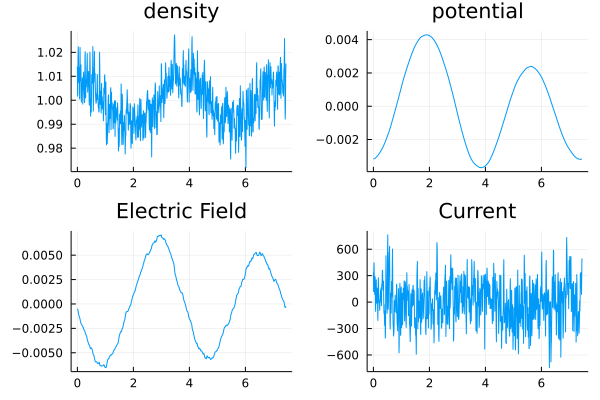

In [27]:
plot(layout=(2,2))
plot!(subplot=1,x,n/n0, title = "density", legend = :false)
plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
plot!(subplot=3,x,E, title = "Electric Field", legend = :false)
plot!(subplot=4,x,S, title = "Current", legend = :false)

Check the histograms for the initial positions and velocities.

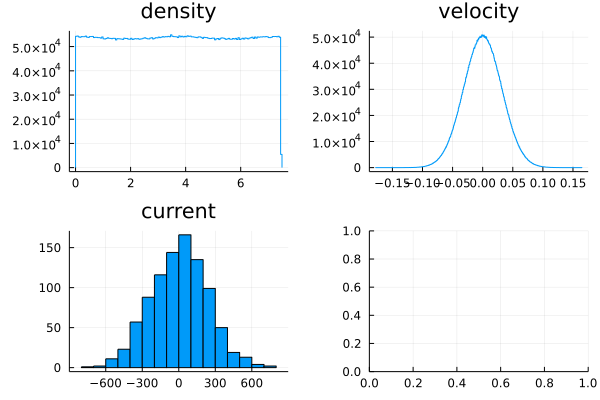

In [28]:
plot(layout=(2,2))
histogram!(subplot=1,u[1:N], title = "density", legend = :false)
histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

histogram!(subplot=3,S, title = "current", legend = :false)

In [29]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
end

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [30]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current!, Interpolate_2) ;
end

Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
E_T = zeros(M_g)
v_T = zeros(M_g)
D_T = zeros(M_g)
S_T = zeros(M_g)
T = zeros(M_g)
if animation
par = zeros(M_g,2N)
end
Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
E_T[1] = sum(u[2N+1:end])
v_T[1] = sum(u[N+1:2N])
get_density!(u, n, p)
get_current!(u, S, p)
D_T[1] = sum(n)/n0/J - 1
S_T[1] = sum(S)/n0/J
T[1] = var(u[N+1:2N])
if animation
par[1,:] = u[1:2N]
end



t = 0.0
j = 1


1

In [ ]:

for k in 2:M
  RK4_Step!(RHSC,u,t,dt,p_RHSC)
  u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    j = j+1
    #scatter(plt, u[1:N], u[N+1:2*N])
    Energy_K[j], Energy_E[j] = get_energy(u,(L, N, J))
    E_T[j] = sum(u[2N+1:end])
    v_T[j] = sum(u[N+1:2N])
    get_density!(u, n, p)
    get_current!(u, S, p)
    D_T[j] = sum(n)/n0/J - 1
    S_T[j] = sum(S)/n0/J
    T[j] = var(u[N+1:2N])
    println("j = $j , t = $t, k = $k, nthreads = $(nthreads())")
    if animation
    par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.1, k = 2, nthreads = 1
j = 3 , t = 0.2, k = 3, nthreads = 1
j = 4 , t = 0.30000000000000004, k = 4, nthreads = 1
j = 5 , t = 0.4, k = 5, nthreads = 1
j = 6 , t = 0.5, k = 6, nthreads = 1
j = 7 , t = 0.6, k = 7, nthreads = 1
j = 8 , t = 0.7, k = 8, nthreads = 1
j = 9 , t = 0.7999999999999999, k = 9, nthreads = 1
j = 10 , t = 0.8999999999999999, k = 10, nthreads = 1
j = 11 , t = 0.9999999999999999, k = 11, nthreads = 1
j = 12 , t = 1.0999999999999999, k = 12, nthreads = 1
j = 13 , t = 1.2, k = 13, nthreads = 1
j = 14 , t = 1.3, k = 14, nthreads = 1
j = 15 , t = 1.4000000000000001, k = 15, nthreads = 1
j = 16 , t = 1.5000000000000002, k = 16, nthreads = 1
j = 17 , t = 1.6000000000000003, k = 17, nthreads = 1
j = 18 , t = 1.7000000000000004, k = 18, nthreads = 1
j = 19 , t = 1.8000000000000005, k = 19, nthreads = 1
j = 20 , t = 1.9000000000000006, k = 20, nthreads = 1
j = 21 , t = 2.0000000000000004, k = 21, nthreads = 1
j = 22 , t = 2.1000000000000005, k = 22, nthreads = 1
j

In [ ]:
n_F = zeros(J)
S_F = zeros(J)
get_density!(u, n_F, p)
get_current!(u, S_F, p)
save(run_name * "th$(nthreads())_results.jld2", Dict("p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T))

## Studying the solutions: 

### Energy:

In [ ]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) , yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png(run_name * "energy_conservation")

In [ ]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

In [ ]:
#ω = 1
#tv = [dt*(i-1) for i in 1:M]
plot(T, label= "θ", title = "Temperature = var", legend = false)
#plot!(sin.(ω*tv))
#png(run_name * "temperature")

34 peaks in T = 100, so $\omega = 0.34$

In [ ]:
Th = rfft(T)
plot(real.(Th))
argmin(real.(Th))*t_f/length(T) * sqrt(θ)
#length(T)

In [ ]:
T[end]

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |


## Total Quantities

In [ ]:
plot(layout=(2,2))
plot!(subplot=1,E_T,title="Total Electric Field")
plot!(subplot=2,v_T./N, title="Total velocity")
plot!(subplot=3,D_T,title = "Total density")
plot!(subplot=4,S_T,title = "Total Current")
#png(run_name * "totals")

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
n_F = zeros(J)
get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,u[2N+1:end], label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

In [ ]:
println("averaged total E field = $(sum(E_F))")
println("E_total = $(sum(u[2N+1:end])/J)")
println("Total velocity = $(sum(u[N+1:2N])/N)")
println("Total Charge = $(sum(n_F .- n0))")
println("Final Energy = $(get_energy(u,(L, N, J)))")
get_current!(u, S, p)
println("Total_current = $(sum(S)/J)")

In [ ]:
plot(x,u[2N+1:end]-E_F, label = "difference", title="Electric Field")
png(run_name * "electric_diff")

In [ ]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
#, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
#png(run_name * "ps")
end

In [ ]:
if animation
    anim = @animate for i = 1:M_g
        Plots.scatter(par[i,1:N], par[i,N+1:2N]
        , markersize = 0.3
        , title = "phase-space"
        , legend=false
        , ylim = (-0.3,0.3)
        , xlim = (0,5)
        )
    end
 
    gif(anim, run_name * "ps_fps5.gif", fps = 5)
end

In [ ]:
load("Results/" * run_name * "results.jld2", "S_F")

In [ ]:
(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/" * run_name * "results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");


In [ ]:
using LsqFit